# Visual Question Answering using Multimodal Transformer Models

In [1]:
!pip install datasets transformers torch nltk scikit-learn pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install datasets --upgrade


In [3]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

# import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score

In [4]:

os.environ['HF_HOME'] = os.path.join(".", "cache")

os.environ['CUDA_VISIBLE_DEVICES'] = '0'


logging.set_verbosity_error()

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))


cuda:0
Tesla T4


## Load the Processed DAQUAR Dataset


All the questions have 1-word/phrase answer, so we consider the entire vocabulary of answers available (*answer space*) & treat them as labels. This converts the visual question answering into a multi-class classification problem.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
os.chdir('/content/drive/MyDrive/dataset')

In [54]:
dataset = load_dataset(
    "csv",
    data_files={
        "train": "data_train.csv",
        "test": "data_eval.csv"
    }
)

with open("answer_space.txt") as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9974 [00:00<?, ? examples/s]

Map:   0%|          | 0/2494 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 2494
    })
})

### Look at some of the Question/Image/Answer combinations

In [56]:
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    image = Image.open(os.path.join("images", data[id]["image_id"] + ".png"))
    display(image)

    print("Questions:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

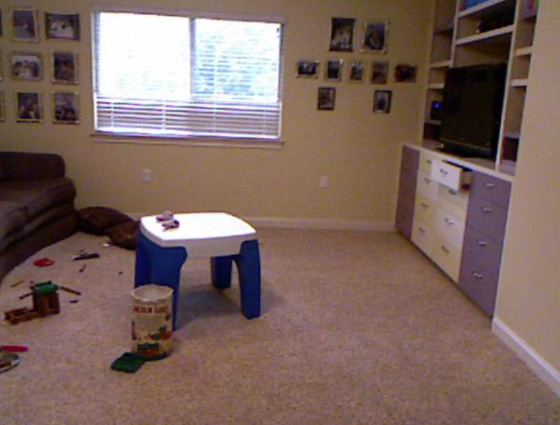

Questions:	 what are the colours of the drawers
Answer:		 purple, white (Label: 407)


In [57]:
showExample()

### Create a Multimodal Collator for the Dataset

In [11]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("..", "dataset", "images", image_id + ".png")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }

    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

## Defining the Multimodal VQA Model Architecture

In [12]:
class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'bert-base-uncased',
            pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):

        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()

    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):

        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)

        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out

### Define a Function to Create the Multimodal VQA Models along with their Collators

In [13]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )


    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

## Performance Metrics from Visual Question Answering

In [14]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a)
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score

In [15]:
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [16]:
import nltk

In [17]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [18]:
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['electric_toothbrush', 'coffee_grinder', 'chandelier', '13', 'excercise_ball']
['balloon', 'bicycle_helmet', 'shelves', 'medal', 'toy_horse']
Predictions vs Labels:  0.029598039215686277
Labels vs Labels:  1.0


In [19]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

## Model Training & Evaluation

### Define the Arguments needed for Training

In [20]:
args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345,
    eval_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,             # Save only the last 3 checkpoints at any given time while training
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=5,
    fp16=True,
    # warmup_ratio=0.01,
    # learning_rate=5e-4,
    # weight_decay=1e-4,
    # gradient_accumulation_steps=2,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
)

### Create the Multimodal Models using User-Defined Text/Image  Transformers & Train it on the Dataset

In [21]:
def createAndTrainModel(dataset, args, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224-in21k', multimodal_model='bert_vit'):
    collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)

    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("..", "checkpoint", multimodal_model)
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )

    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()

    return collator, model, train_multi_metrics, eval_multi_metrics

In [22]:
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arushiaro (arushiaro-indian-institute-of-technology-guwahati) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'loss': 5.7536, 'grad_norm': 5.8168721199035645, 'learning_rate': 4.682692307692308e-05, 'epoch': 0.32051282051282054}
{'eval_loss': 5.1289286613464355, 'eval_wups': 0.135673005470676, 'eval_acc': 0.0804090635652697, 'eval_f1': 0.0007519068280321888, 'eval_runtime': 181.7741, 'eval_samples_per_second': 54.87, 'eval_steps_per_second': 1.716, 'epoch': 0.32051282051282054}
{'loss': 4.9885, 'grad_norm': 5.986744403839111, 'learning_rate': 4.362179487179487e-05, 'epoch': 0.6410256410256411}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 4.579349517822266, 'eval_wups': 0.17222860474904175, 'eval_acc': 0.1137958692600762, 'eval_f1': 0.0023963168072910876, 'eval_runtime': 185.1015, 'eval_samples_per_second': 53.884, 'eval_steps_per_second': 1.686, 'epoch': 0.6410256410256411}
{'loss': 4.6904, 'grad_norm': 6.18241548538208, 'learning_rate': 4.041666666666667e-05, 'epoch': 0.9615384615384616}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 4.314126491546631, 'eval_wups': 0.20326844700186936, 'eval_acc': 0.13765791056747545, 'eval_f1': 0.004617418738316828, 'eval_runtime': 178.2428, 'eval_samples_per_second': 55.957, 'eval_steps_per_second': 1.75, 'epoch': 0.9615384615384616}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'loss': 4.404, 'grad_norm': 6.106921672821045, 'learning_rate': 3.7211538461538466e-05, 'epoch': 1.282051282051282}
{'eval_loss': 4.077351093292236, 'eval_wups': 0.23505243090368083, 'eval_acc': 0.17194706236214158, 'eval_f1': 0.005652489046651862, 'eval_runtime': 181.4573, 'eval_samples_per_second': 54.966, 'eval_steps_per_second': 1.719, 'epoch': 1.282051282051282}
{'loss': 4.2296, 'grad_norm': 5.6078667640686035, 'learning_rate': 3.400641025641026e-05, 'epoch': 1.6025641025641026}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 3.9436256885528564, 'eval_wups': 0.24281518095248694, 'eval_acc': 0.18688590334870664, 'eval_f1': 0.006741174462625828, 'eval_runtime': 182.438, 'eval_samples_per_second': 54.671, 'eval_steps_per_second': 1.71, 'epoch': 1.6025641025641026}
{'loss': 4.0692, 'grad_norm': 6.693305015563965, 'learning_rate': 3.0801282051282055e-05, 'epoch': 1.9230769230769231}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 3.821606159210205, 'eval_wups': 0.25468402221105124, 'eval_acc': 0.20082213755764988, 'eval_f1': 0.008046165453371066, 'eval_runtime': 179.5777, 'eval_samples_per_second': 55.541, 'eval_steps_per_second': 1.737, 'epoch': 1.9230769230769231}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'loss': 3.9686, 'grad_norm': 5.95164680480957, 'learning_rate': 2.7628205128205133e-05, 'epoch': 2.2435897435897436}
{'eval_loss': 3.7094035148620605, 'eval_wups': 0.26902652894419293, 'eval_acc': 0.2155604571886906, 'eval_f1': 0.009659064091464595, 'eval_runtime': 180.8029, 'eval_samples_per_second': 55.165, 'eval_steps_per_second': 1.726, 'epoch': 2.2435897435897436}
{'loss': 3.8515, 'grad_norm': 5.921082496643066, 'learning_rate': 2.4423076923076924e-05, 'epoch': 2.564102564102564}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 3.63314151763916, 'eval_wups': 0.2769792441238159, 'eval_acc': 0.22468417886504913, 'eval_f1': 0.01140045281659093, 'eval_runtime': 180.427, 'eval_samples_per_second': 55.28, 'eval_steps_per_second': 1.729, 'epoch': 2.564102564102564}
{'loss': 3.8342, 'grad_norm': 5.960424423217773, 'learning_rate': 2.1217948717948718e-05, 'epoch': 2.8846153846153846}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 3.5510647296905518, 'eval_wups': 0.2921224576319773, 'eval_acc': 0.23982354120713856, 'eval_f1': 0.013595137989138043, 'eval_runtime': 176.9415, 'eval_samples_per_second': 56.369, 'eval_steps_per_second': 1.763, 'epoch': 2.8846153846153846}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'loss': 3.6912, 'grad_norm': 6.062711238861084, 'learning_rate': 1.8012820512820512e-05, 'epoch': 3.2051282051282053}
{'eval_loss': 3.4653027057647705, 'eval_wups': 0.31235842971099925, 'eval_acc': 0.2631842791257269, 'eval_f1': 0.015807745649377165, 'eval_runtime': 178.1069, 'eval_samples_per_second': 56.0, 'eval_steps_per_second': 1.752, 'epoch': 3.2051282051282053}
{'loss': 3.6275, 'grad_norm': 7.934411525726318, 'learning_rate': 1.4807692307692308e-05, 'epoch': 3.5256410256410255}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 3.416736602783203, 'eval_wups': 0.31302784972312253, 'eval_acc': 0.26298375777020255, 'eval_f1': 0.016363969804627124, 'eval_runtime': 176.5574, 'eval_samples_per_second': 56.492, 'eval_steps_per_second': 1.767, 'epoch': 3.5256410256410255}
{'loss': 3.6406, 'grad_norm': 6.758312225341797, 'learning_rate': 1.1602564102564104e-05, 'epoch': 3.8461538461538463}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 3.3593695163726807, 'eval_wups': 0.3230655642990085, 'eval_acc': 0.2735111289352316, 'eval_f1': 0.018038931969654934, 'eval_runtime': 176.6524, 'eval_samples_per_second': 56.461, 'eval_steps_per_second': 1.766, 'epoch': 3.8461538461538463}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'loss': 3.5348, 'grad_norm': 6.148832321166992, 'learning_rate': 8.397435897435898e-06, 'epoch': 4.166666666666667}
{'eval_loss': 3.315595865249634, 'eval_wups': 0.33433885308541195, 'eval_acc': 0.285341888911169, 'eval_f1': 0.019684075582089663, 'eval_runtime': 179.389, 'eval_samples_per_second': 55.6, 'eval_steps_per_second': 1.739, 'epoch': 4.166666666666667}
{'loss': 3.4592, 'grad_norm': 6.5398712158203125, 'learning_rate': 5.192307692307693e-06, 'epoch': 4.487179487179487}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 3.2849559783935547, 'eval_wups': 0.33720458312267027, 'eval_acc': 0.28915179466613194, 'eval_f1': 0.020281699834413067, 'eval_runtime': 178.3819, 'eval_samples_per_second': 55.914, 'eval_steps_per_second': 1.749, 'epoch': 4.487179487179487}
{'loss': 3.5244, 'grad_norm': 6.080970764160156, 'learning_rate': 1.987179487179487e-06, 'epoch': 4.8076923076923075}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 3.2692151069641113, 'eval_wups': 0.3428306426467299, 'eval_acc': 0.2955684780429116, 'eval_f1': 0.021089879605526187, 'eval_runtime': 178.7442, 'eval_samples_per_second': 55.8, 'eval_steps_per_second': 1.746, 'epoch': 4.8076923076923075}
{'train_runtime': 3952.5758, 'train_samples_per_second': 12.617, 'train_steps_per_second': 0.395, 'train_loss': 4.059214772933569, 'epoch': 5.0}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 3.2692151069641113, 'eval_wups': 0.3428306426467299, 'eval_acc': 0.2955684780429116, 'eval_f1': 0.021089879605526187, 'eval_runtime': 167.1861, 'eval_samples_per_second': 59.658, 'eval_steps_per_second': 1.866, 'epoch': 5.0}


In [23]:
eval_multi_metrics

{'eval_loss': 3.2692151069641113,
 'eval_wups': 0.3428306426467299,
 'eval_acc': 0.2955684780429116,
 'eval_f1': 0.021089879605526187,
 'eval_runtime': 167.1861,
 'eval_samples_per_second': 59.658,
 'eval_steps_per_second': 1.866,
 'epoch': 5.0}

## Examples of Model Inferencing

### Loading the Model from Checkpoint

In [29]:
!pwd

/content/drive/MyDrive/dataset


In [31]:
# Check what's in your main checkpoint directory
!ls /content/drive/MyDrive/checkpoint/

# Then check the bert_vit directory if it exists
!ls /content/drive/MyDrive/checkpoint/bert_vit/

bert_vit
checkpoint-1400  checkpoint-1500  checkpoint-1560


In [32]:
!ls /content/drive/MyDrive/checkpoint/bert_vit/checkpoint-1500/

model.safetensors  scheduler.pt		    trainer_state.json
optimizer.pt	   special_tokens_map.json  training_args.bin
rng_state.pth	   tokenizer_config.json    vocab.txt
scaler.pt	   tokenizer.json


In [34]:
model = MultimodalVQAModel()
from safetensors.torch import load_file
checkpoint_path = "/content/drive/MyDrive/checkpoint/bert_vit/checkpoint-1560/model.safetensors"

# Load the state dictionary using safetensors
state_dict = load_file(checkpoint_path)
model.load_state_dict(state_dict)
# We use the checkpoint giving best results
#model.load_state_dict(torch.load(os.path.join("..", "checkpoint", "bert_vit", "checkpoint-1500", "pytorch_model.bin")))
model.to(device)

MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [36]:
sample = collator(dataset["test"][2000:2005])

input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

### Pass the Samples through the Model & inspect the Predictions

In [58]:
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

In [59]:
preds = output["logits"].argmax(axis=-1).cpu().numpy()
preds

array([ 61,  43,  14, 308, 568])

*********************************************************


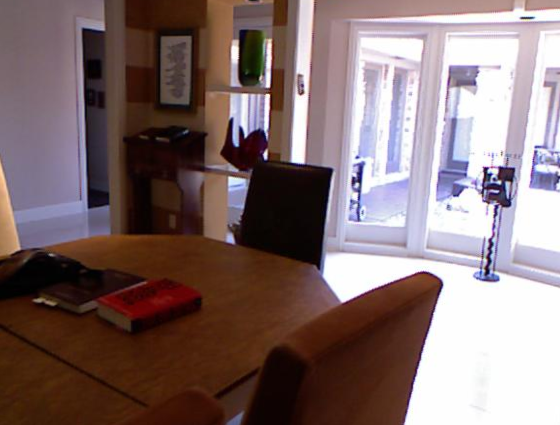

Questions:	 what are the things in the rack
Answer:		 framed_certificate, vase (Label: 229)
Predicted Answer:	 books
*********************************************************
*********************************************************


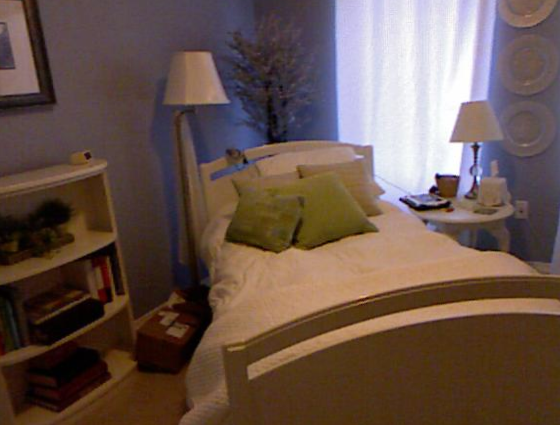

Questions:	 what is to the right of the bed
Answer:		 table (Label: 483)
Predicted Answer:	 bed
*********************************************************
*********************************************************


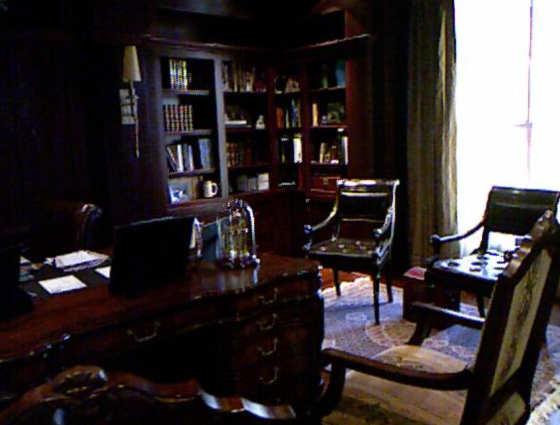

Questions:	 how many drawers are there
Answer:		 6 (Label: 16)
Predicted Answer:	 4
*********************************************************
*********************************************************


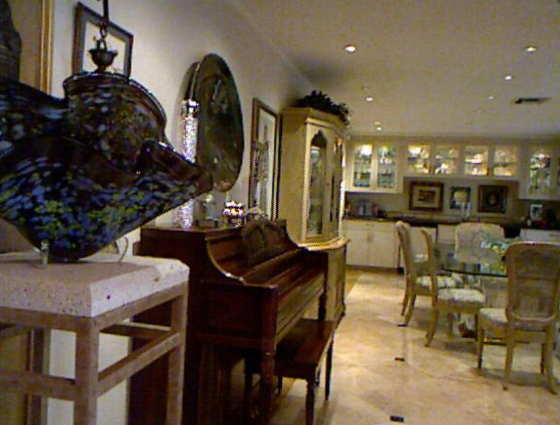

Questions:	 what is on the stool
Answer:		 decorative_item (Label: 156)
Predicted Answer:	 lamp
*********************************************************
*********************************************************


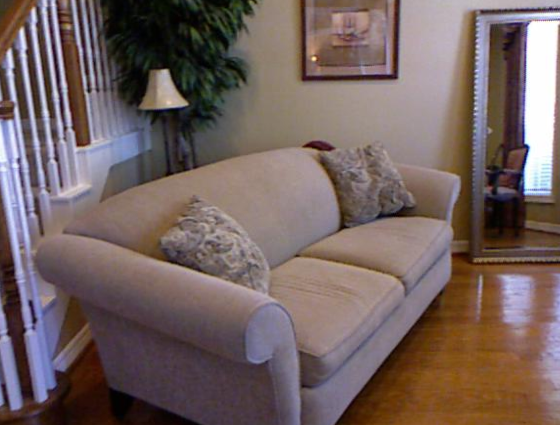

Questions:	 what is in the corner near the banister
Answer:		 plant (Label: 390)
Predicted Answer:	 window
*********************************************************


In [39]:
for i in range(2000, 2005):
    print("*********************************************************")
    showExample(train=False, id=i)
    print("Predicted Answer:\t", answer_space[preds[i-2000]])
    print("*********************************************************")

## Inspecting Model Size

In [40]:
def countTrainableParameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of trainable parameters:\t{0:,}".format(num_params))

In [41]:
countTrainableParameters(model) # For BERT-ViT model

No. of trainable parameters:	196,956,998


In [44]:
!zip -r /content/checkpoint_bert_vit1.zip /content/drive/MyDrive/checkpoint/bert_vit/checkpoint-1560

  adding: content/drive/MyDrive/checkpoint/bert_vit/checkpoint-1560/ (stored 0%)
  adding: content/drive/MyDrive/checkpoint/bert_vit/checkpoint-1560/model.safetensors (deflated 7%)
  adding: content/drive/MyDrive/checkpoint/bert_vit/checkpoint-1560/tokenizer_config.json (deflated 75%)
  adding: content/drive/MyDrive/checkpoint/bert_vit/checkpoint-1560/special_tokens_map.json (deflated 42%)
  adding: content/drive/MyDrive/checkpoint/bert_vit/checkpoint-1560/vocab.txt (deflated 53%)
  adding: content/drive/MyDrive/checkpoint/bert_vit/checkpoint-1560/tokenizer.json (deflated 71%)
  adding: content/drive/MyDrive/checkpoint/bert_vit/checkpoint-1560/training_args.bin (deflated 51%)
  adding: content/drive/MyDrive/checkpoint/bert_vit/checkpoint-1560/optimizer.pt (deflated 19%)
  adding: content/drive/MyDrive/checkpoint/bert_vit/checkpoint-1560/scheduler.pt (deflated 55%)
  adding: content/drive/MyDrive/checkpoint/bert_vit/checkpoint-1560/scaler.pt (deflated 60%)
  adding: content/drive/MyDriv

In [46]:
!cp /content/checkpoint_bert_vit1.zip /content/drive/MyDrive/

In [47]:
import wandb
api = wandb.Api()

# Get your specific run
run = api.run("arushiaro-indian-institute-of-technology-guwahati/huggingface/i8xjik28")

# Export metrics to CSV
metrics_df = run.history()
metrics_df.to_csv("run_metrics.csv")

# Export config
config_dict = {k: v for k, v in run.config.items() if not k.startswith('_')}
import json
with open("run_config.json", "w") as f:
    json.dump(config_dict, f)

In [48]:
# List artifacts
artifacts = run.logged_artifacts()

# Download each artifact
for artifact in artifacts:
    artifact_dir = artifact.download()
    print(f"Downloaded {artifact.name} to {artifact_dir}")

In [51]:
from google.colab import files


# Force download in browser
files.download('/content/checkpoint_bert_vit1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>